### Imports

In [1]:
import sys
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from torch.autograd import Function
from torch.optim import Adam
from graphviz import Source
from pyeda.boolalg.bdd import bdd2expr

filepath = os.path.abspath('')
sys.path.append(os.path.join(filepath, "..", "..", "compiling_nn"))
from build_odd import compile_nn

In [2]:
def plot_cm(y_true, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix, display_labels=[False, True])
    cm_display.plot()

def tnot(a): return torch.logical_not(a)
def tor(a,b): return torch.logical_or(a,b)
def tand(a,b): return torch.logical_and(a,b)
def txor(a,b): return torch.logical_xor(a,b)

### Networks class and Custom Activation/Loss

In [3]:
class BigNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        x = self.nn(x)
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,1),
            StepActivation()
        )

    def forward(self, x):
        x = self.nn(x)
        return x
    
######################################################

class StepFunction(Function):
    @staticmethod
    def forward(ctx, input):
        output = torch.where(input>=0, torch.tensor(1.0), torch.tensor(0.0))
        ctx.save_for_backward(input)
        return output
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = torch.zeros_like(input)
        return grad_input
    
class StepActivation(nn.Module):
    def forward(self, input):
        if self.training:
            return torch.sigmoid(input)
        else:
            return StepFunction.apply(input)

class ExpLoss(nn.Module): # https://www.desmos.com/calculator/1gtkyr1dlm
    def __init__(self, lower_bound=0, upper_bound=1, b=1.00, base_pow=None, reduction='mean'):
        super(ExpLoss, self).__init__()
        self.coef_div = upper_bound - lower_bound
        self.coef_mul = b
        self.coef_all = self.coef_mul/self.coef_div
        self.base_pow = base_pow

        self.mean_reduction = reduction=='mean'
        self.sum_reduction = reduction=='sum'

    def forward(self, input, label):
        if self.base_pow:
            loss = torch.abs(torch.pow(exponent=(input - label)*self.coef_all, self=self.base_pow) - 1)
        else:
            loss = torch.abs(torch.exp((input - label)*self.coef_all) - 1)

        if self.mean_reduction:
            loss = torch.mean(loss)
        elif self.sum_reduction:
            loss = torch.sum(loss)

        return loss
    
class AsymMSELoss(nn.Module): # https://www.desmos.com/calculator/zmxcluqhkt
    def __init__(self, p=2):
        super(AsymMSELoss, self).__init__()
        self.p = p

    def forward(self, input, label):
        dif = label - input
        a = torch.square(dif)
        b = a*self.p
        loss = torch.where(dif < 0, b, a)
        loss = torch.mean(loss)
        return loss
    
"""class TestLoss(Function):
    def __init__(self):
        self.func = lambda xhi, xnn, xlo : tor(tand(tnot(txor(xhi, xlo)), xhi), tand(txor(xhi, xlo), xnn)).float()

    def forward(self, input1, input2, input3, label):
        self.save_for_backward(input1, input2, input3, label)
        
    def backward(self, grad_output):
        input1, input2, input3, label = self.saved_tensors"""

'class TestLoss(Function):\n    def __init__(self):\n        self.func = lambda xhi, xnn, xlo : tor(tand(tnot(txor(xhi, xlo)), xhi), tand(txor(xhi, xlo), xnn)).float()\n\n    def forward(self, input1, input2, input3, label):\n        self.save_for_backward(input1, input2, input3, label)\n        \n    def backward(self, grad_output):\n        input1, input2, input3, label = self.saved_tensors'

### Data preprocessing

In [4]:
df = pd.read_csv("loan_data_set.csv", sep=",")
df = df.drop(columns=["Loan_ID"])

df_y = pd.get_dummies(df[["Loan_Status"]], drop_first=True)
df_x = df.drop(columns=["Loan_Status"])

nunique = df_x.nunique(axis=0)
df_x_mean = df_x.mean(axis=0, numeric_only=True)

for col, n in nunique.items():
    if n > 4:
        df_x[col] = df_x[col].apply(lambda x : min(4, x//(.5*df_x_mean[col])))

df_x = pd.get_dummies(df_x, columns=df_x.columns, drop_first=True)

itrue = df_y.index[df_y["Loan_Status_Y"]==1].tolist()
ifalse = df_y.index[df_y["Loan_Status_Y"]==0].tolist()

swap = len(itrue) > len(ifalse)
if swap:
    itrue,ifalse=ifalse,itrue

ifalse = random.choices(ifalse, k=len(itrue))

if swap:
    itrue,ifalse=ifalse,itrue

print(df_y.iloc[itrue+ifalse].value_counts())

x=torch.Tensor(df_x.iloc[itrue+ifalse].to_numpy(dtype=int))
y=torch.Tensor(df_y.iloc[itrue+ifalse].to_numpy(dtype=int))

print(x.shape, y.shape)

Loan_Status_Y
0                192
1                192
dtype: int64
torch.Size([384, 25]) torch.Size([384, 1])


### Train Big Network

In [5]:
bignet = BigNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn = nn.BCELoss()
optimizer = Adam(bignet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bignet.train()
    y_pred = bignet(x)
    loss = loss_fn(y_pred, y)

    bignet.zero_grad()
    loss.backward()
    optimizer.step()

    bignet.eval()
    y_pred_step = bignet(x)
    loss_step = loss_fn(y_pred_step, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.6046056747436523 30.72916603088379
0.512468695640564 25.78125
0.361259788274765 11.979166984558105
0.19114230573177338 5.729166507720947
0.09510954469442368 3.3854167461395264
0.06554293632507324 3.125
0.059729497879743576 3.125
0.057253647595644 3.125
0.05593491718173027 3.125
0.05507950484752655 3.125
0.05472789704799652 3.125
0.054089706391096115 3.125
0.05377001687884331 3.125
0.053542301058769226 3.125
0.05333426967263222 3.125
0.05326679348945618 3.125
0.05305340886116028 3.125
0.05293522775173187 3.125
0.05299954488873482 3.125
0.05277223512530327 3.125


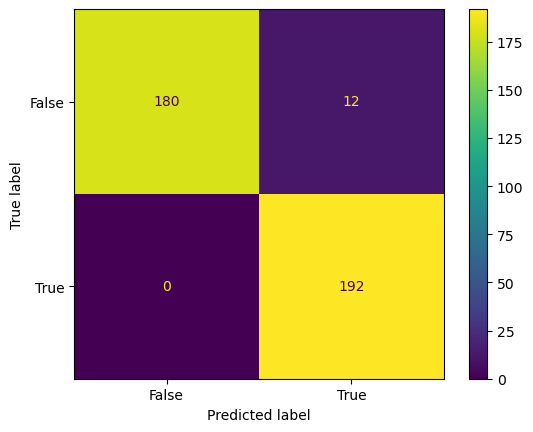

In [6]:
bignet.eval()
y_pred_big = bignet(x).detach().numpy()
plot_cm(y, y_pred_big)
plt.show()

### Train Small Network with Custom Loss (ExpLoss)

In [7]:
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = ExpLoss(base_pow=1.5, upper_bound=1, lower_bound=0)
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.maximum(bignet(x), y).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn_small(y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.17606425285339355 0.1640624850988388
0.16272886097431183 0.1323784589767456
0.15250147879123688 0.1219618022441864
0.1445743888616562 0.1184895858168602
0.1375763863325119 0.1115451231598854
0.13216808438301086 0.1128472164273262
0.12796656787395477 0.1128472164273262
0.12456381320953369 0.109375
0.12171713262796402 0.1032986119389534
0.1192832812666893 0.1006944477558136
0.11717414855957031 0.1028645858168602
0.11532961577177048 0.0998263880610466
0.1137029230594635 0.0998263880610466
0.11225572973489761 0.0993923619389534
0.11095660924911499 0.0980902686715126
0.10978002101182938 0.0972222164273262
0.10870543867349625 0.0959201380610466
0.1077163890004158 0.0959201380610466
0.1067996621131897 0.0946180522441864
0.10594474524259567 0.0946180522441864


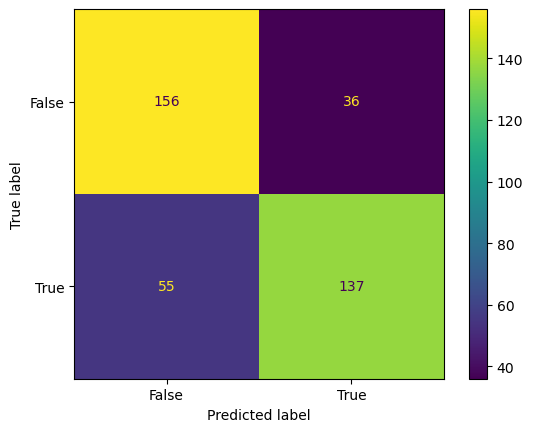

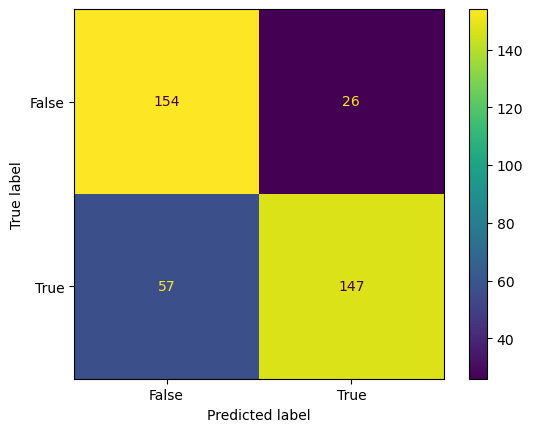

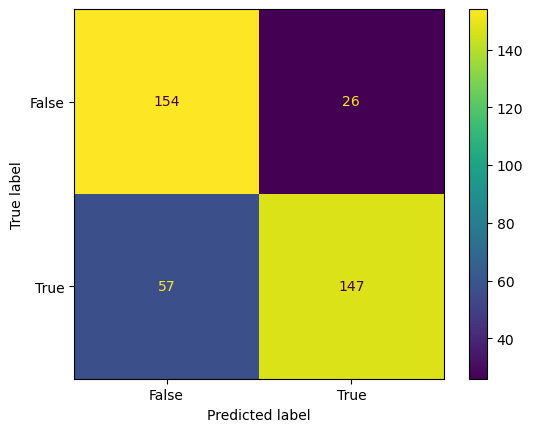

In [8]:
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

### Train Small Network with BCELoss

In [9]:
smallnet = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_small = nn.BCELoss()
optimizer = Adam(smallnet.parameters(), lr=learning_rate)

y_target = torch.minimum(bignet(x), y).detach()

for epoch in range(max_epoch):
    smallnet.train()
    y_pred_small = smallnet(x)
    loss = loss_fn_small(y_pred_small, y_target)

    smallnet.zero_grad()
    loss.backward()
    optimizer.step()

    smallnet.eval()
    y_pred_step_small = smallnet(x)
    loss_step = loss_fn(y_pred_step_small, y)
    if (epoch+1)%50==0:
        print(loss.item(), loss_step.item())

0.6304318308830261 33.85416793823242
0.5933327674865723 28.90625
0.571640133857727 29.94791603088379
0.5584797859191895 28.64583396911621
0.550501823425293 28.90625
0.5456721186637878 28.64583396911621
0.542730987071991 28.90625
0.5409113764762878 28.38541603088379
0.5397542119026184 28.38541603088379
0.5389898419380188 28.64583396911621
0.5384621024131775 28.64583396911621
0.5380824208259583 28.38541603088379
0.537800133228302 28.38541603088379
0.5375861525535583 28.38541603088379
0.5374227166175842 28.38541603088379
0.5372981429100037 28.64583396911621
0.5372039675712585 28.64583396911621
0.5371338725090027 28.64583396911621
0.537082314491272 28.38541603088379
0.5370450019836426 28.38541603088379


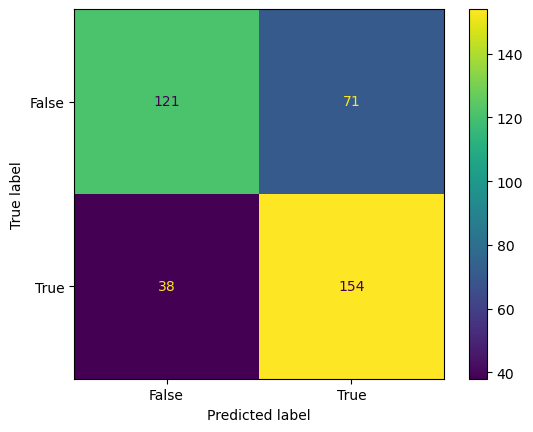

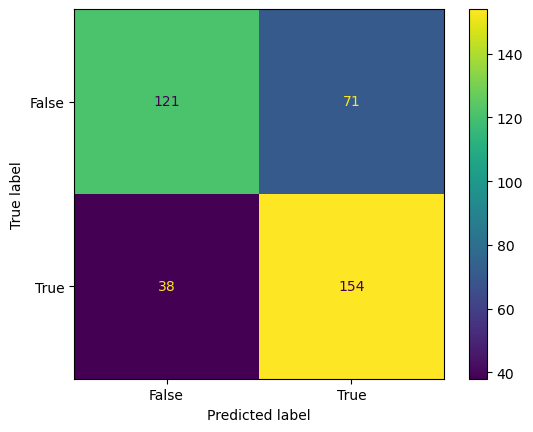

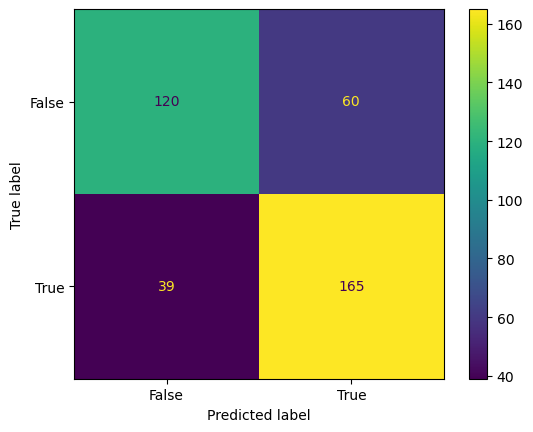

In [10]:
smallnet.eval()
y_pred_small = smallnet(x).detach().numpy()
confusion_matrix_true = metrics.confusion_matrix(y, y_pred_small)
confusion_matrix_target = metrics.confusion_matrix(y_target, y_pred_small)
confusion_matrix_big = metrics.confusion_matrix(y_pred_big, y_pred_small)

cm_display_true   = metrics.ConfusionMatrixDisplay(confusion_matrix_true, display_labels=[False, True])
cm_display_target = metrics.ConfusionMatrixDisplay(confusion_matrix_target, display_labels=[False, True])
cm_display_big    = metrics.ConfusionMatrixDisplay(confusion_matrix_big, display_labels=[False, True])

cm_display_true.plot()
cm_display_target.plot()
cm_display_big.plot()
plt.show()

### Combined training ExpLoss

In [11]:
hi_net = SmallNet()
bignet = BigNet()
lo_net = SmallNet()

max_epoch = 1000
learning_rate = 1e-2

loss_fn_hi = ExpLoss(base_pow=1.4, upper_bound=1, lower_bound=0) # more penalty for false 1 
loss_fn_big= nn.BCELoss()
loss_fn_lo = ExpLoss(base_pow=1.2, upper_bound=0, lower_bound=1) # more penalty for false 0

# 3 separate optimizer 
optimizer1 = Adam(hi_net.parameters(), lr=learning_rate)
optimizer2 = Adam(bignet.parameters(), lr=learning_rate)
optimizer3 = Adam(lo_net.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    hi_net.train()
    bignet.train()
    lo_net.train()

    y_pred_hi = hi_net(x)
    y_pred_big= bignet(x)
    y_pred_lo = lo_net(x)

    y_target_hi = y_pred_big.detach()
    y_target_lo = y_pred_big.detach()
    # y_target_hi = torch.maximum(y_pred_big.detach(), y)
    # y_target_lo = torch.minimum(y_pred_big.detach(), y)
    loss_hi = loss_fn_hi(y_pred_hi, y_target_hi)
    loss_big= loss_fn_big(y_pred_big, y)
    loss_lo = loss_fn_lo(y_pred_lo, y_target_lo)

    hi_net.zero_grad()
    bignet.zero_grad()
    lo_net.zero_grad()
    loss_hi.backward()
    loss_big.backward()
    loss_lo.backward()
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

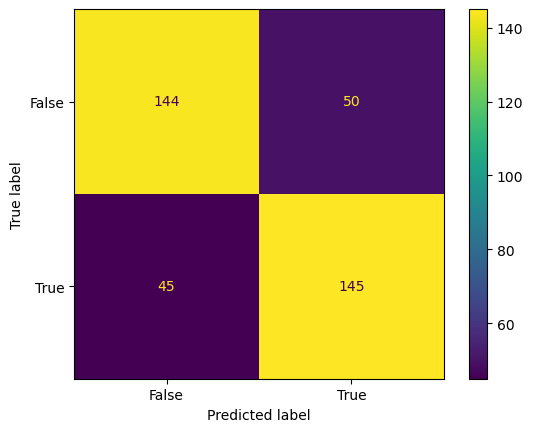

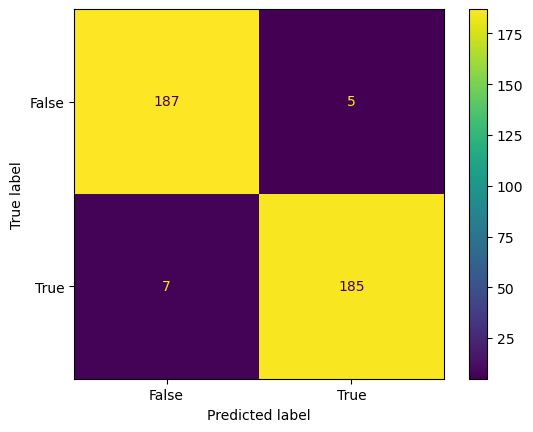

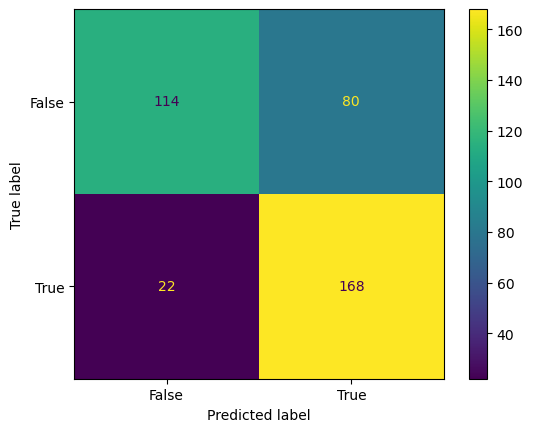

In [12]:
hi_net.eval()
bignet.eval()
lo_net.eval()
y_pred_hi   = hi_net(x).detach().numpy()
y_pred_big  = bignet(x).detach().numpy()
y_pred_lo   = lo_net(x).detach().numpy()
plot_cm(y_pred_big, y_pred_hi)
plot_cm(y, y_pred_big)
plot_cm(y_pred_big, y_pred_lo)
plt.show()

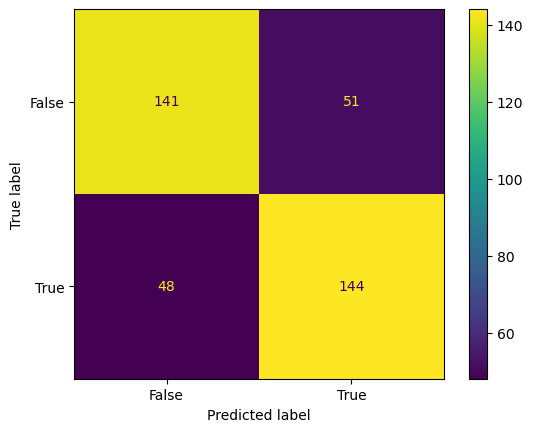

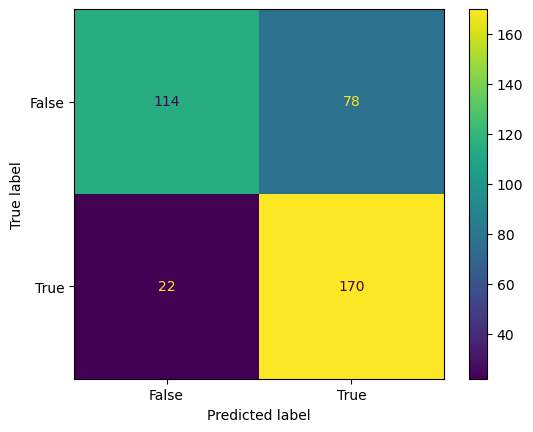

In [13]:
confusion_matrix_hi2 = metrics.confusion_matrix(y, y_pred_hi)
confusion_matrix_lo2 = metrics.confusion_matrix(y, y_pred_lo)

cm_display_hi2   = metrics.ConfusionMatrixDisplay(confusion_matrix_hi2, display_labels=[False, True])
cm_display_lo2   = metrics.ConfusionMatrixDisplay(confusion_matrix_lo2, display_labels=[False, True])

cm_display_hi2.plot()
cm_display_lo2.plot()
plt.show()

### Combined training AsymMSELoss + small degradation

In [88]:
class Approx(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(25,5)
        self.a1 = StepActivation()
        self.l2 = nn.Linear(5,1)
        self.a2 = StepActivation()
        

    def forward(self, x):
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)

        return x

class BNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # high approx nn (bigger = harder to compute into ODD)
        self.hi = Approx()

        # low approx nn
        self.lo = Approx()

        # nn to approximate (can make it bigger easily)
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation(),
        )

    def forward(self, x):
        xhi = self.hi(x)
        xnn = self.nn(x)
        xlo = self.lo(x)

        x = tor(tand(tnot(txor(xhi, xlo)), xhi), tand(txor(xhi, xlo), xnn)).float()
        # x.requires_grad=True
        return {"hi": xhi, "nn": xnn, "lo": xlo, "mn": x}

In [92]:
bnet = BNet()

max_epoch = 5000 # less than 5000 can easily lead to one approx predict only one label
learning_rate = 1e-2

# A loss function for each nn
loss_hi_nn = AsymMSELoss(100) # Asymetrical loss -> greater penalty for ones
loss_lo_nn = AsymMSELoss(.001)#                  -> lesser penalty for ones
loss_nn_tr = nn.BCELoss()

# One optimizer for all parameters
optimizer = Adam(bnet.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bnet.train()
    y_pred = bnet(x)
    
    # loss in comparison with true y values
    loss_nn = loss_nn_tr(y_pred["nn"], y)

    # losses in comparison to y values of the trained nn
    y_target = y_pred["nn"].detach()
    loss_hi = loss_hi_nn(y_pred["hi"], y_target)
    loss_lo = loss_lo_nn(y_pred["lo"], y_target)

    bnet.zero_grad()
    loss_nn.backward()
    loss_hi.backward()
    loss_lo.backward()
    optimizer.step()

In [94]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def print_activation(name, output):
    act = activation[name].squeeze()
    act_ones  = torch.where(output==1, act, torch.zeros(act.size()))
    act_zeros = torch.where(output==0, act, torch.zeros(act.size()))

    print(torch.mean(act_ones, dim=0), torch.mean(act_zeros, dim=0))

bnet.hi.eval()
bnet.hi.l1.register_forward_hook(get_activation('l1_hi'))
output = bnet.hi(x).detach()
print_activation('l1_hi', output)
bnet.lo.eval()
bnet.lo.l1.register_forward_hook(get_activation('l1_lo'))
output = bnet.lo(x).detach()
print_activation('l1_lo', output)

tensor([-0.9548, -1.4412,  0.4207, -1.8080,  1.5596]) tensor([ 7.1943, -4.1365,  0.7926,  6.8614,  3.1221])
tensor([ 6.3359, -0.3791,  6.3503,  3.9421,  0.6686]) tensor([-1.1018,  0.7196, -0.6618, -0.7927,  1.1799])


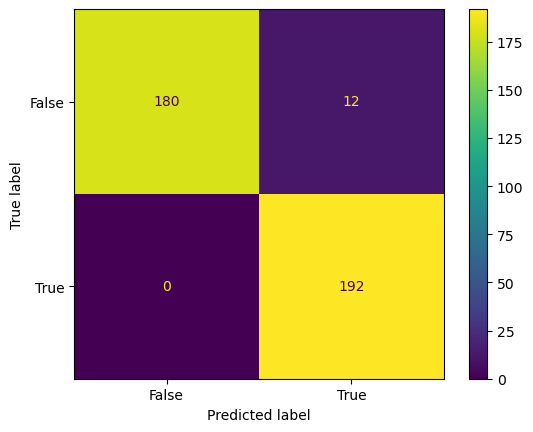

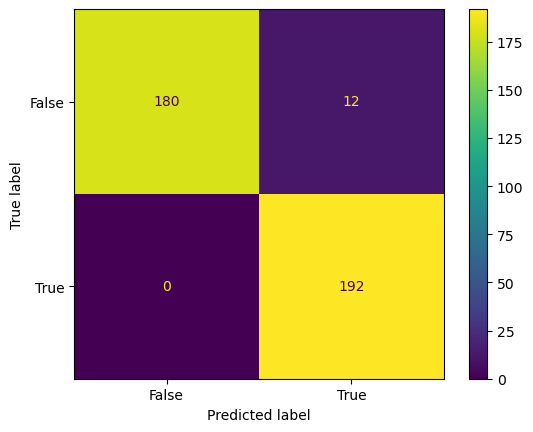

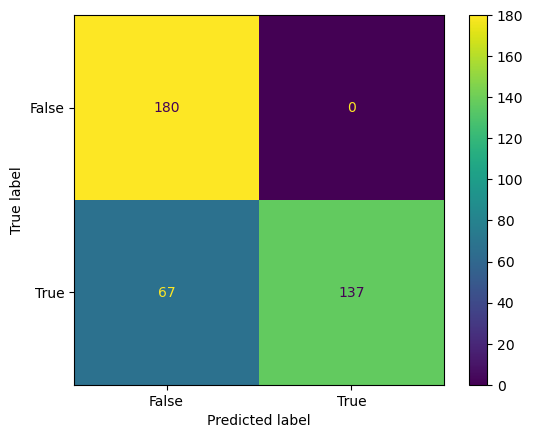

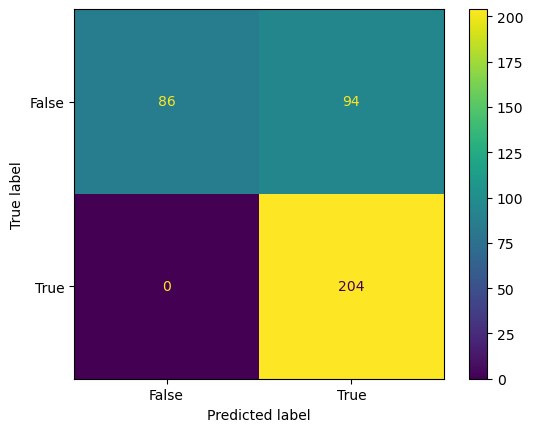

In [82]:
bnet.eval()
y_pred = bnet(x)
y_pred_mn = y_pred["mn"].detach() # prediction for whole nns combined with the logical layer
y_pred_nn = y_pred["nn"].detach() # prediction for accurate nn
y_pred_hi = y_pred["hi"].detach() # prediction for high approximation
y_pred_lo = y_pred["lo"].detach() # prediction for low approximation

plot_cm(y, y_pred_mn)
plot_cm(y, y_pred_nn)
plot_cm(y_pred_nn, y_pred_hi)
plot_cm(y_pred_nn, y_pred_lo)
plt.show()

degrade nn performance slightly (if approx are already close to nn)

In [47]:
""" new target for the big nn """
hi_target = torch.where(torch.logical_and(y_pred_nn == 0, y_pred_hi == 1), torch.full(y_pred_nn.size(), 1), y_pred_nn)
# print(torch.logical_and(y_pred_nn == 0, y_pred_hi == 1).nonzero())
hilo_target = torch.where(torch.logical_and(y_pred_nn == 1, y_pred_lo == 0), torch.full(y_pred_nn.size(), 0), hi_target)
# print(torch.logical_and(y_pred_nn == 1, y_pred_lo == 0).nonzero())

max_epoch = 5000
learning_rate = 1e-2

optimizer = Adam(bnet.nn.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    bnet.nn.train()
    y_pred = bnet.nn(x)
    loss_nn = loss_nn_tr(y_pred, hilo_target)

    bnet.nn.zero_grad()
    loss_nn.backward()
    optimizer.step()

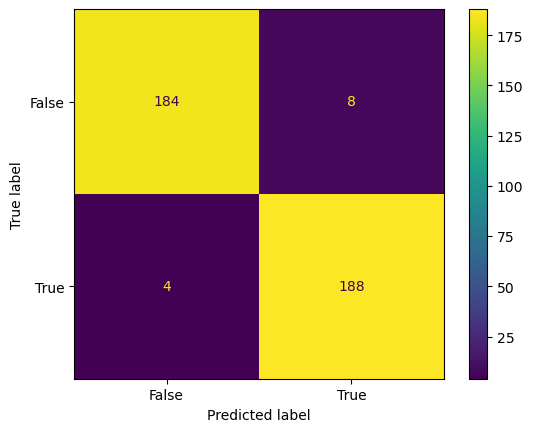

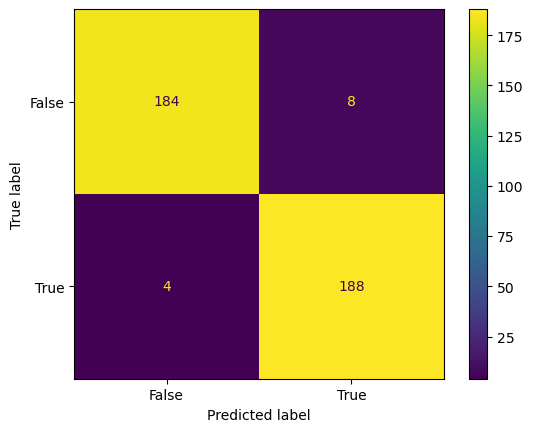

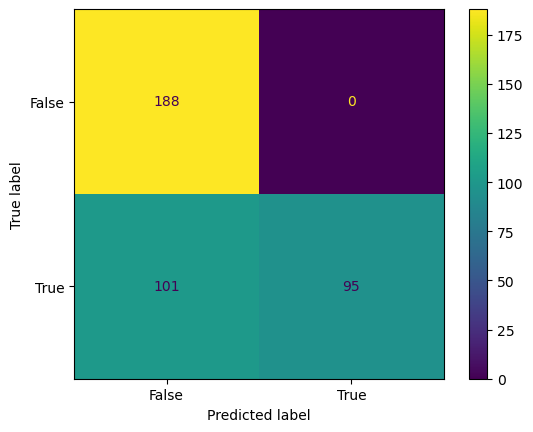

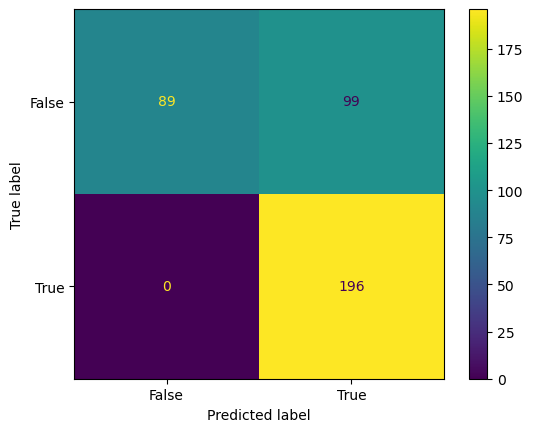

In [48]:
bnet.eval()
y_pred = bnet(x)
y_pred_mn = y_pred["mn"].detach()
y_pred_nn = y_pred["nn"].detach()
y_pred_hi = y_pred["hi"].detach()
y_pred_lo = y_pred["lo"].detach()

plot_cm(y, y_pred_mn)
plot_cm(y, y_pred_nn)
plot_cm(y_pred_nn, y_pred_hi)
plot_cm(y_pred_nn, y_pred_lo)
plt.show()

In [49]:
sys.exit()

SystemExit: 

/home/mbrassart001/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3556: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Test

In [ ]:
class HiNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,5),
            StepActivation(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        return self.nn(x)

class LoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,5),
            StepActivation(),
            nn.Linear(5,1),
            StepActivation()
        )
    
    def forward(self, x):
        return self.nn(x)

class GrNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(25,25),
            nn.Sigmoid(),
            nn.Linear(25,5),
            nn.Sigmoid(),
            nn.Linear(5,1),
            StepActivation()
        )

    def forward(self, x):
        return self.nn(x)

In [ ]:
a = HiNet()
b = GrNet()
c = LoNet()

max_epoch = 5000 
learning_rate = 1e-2

loss_a = AsymMSELoss(100)
loss_b = nn.BCELoss()
loss_c = AsymMSELoss(0.01)

opti_a = Adam(a.parameters(), lr=learning_rate)
opti_b = Adam(b.parameters(), lr=learning_rate)
opti_c = Adam(c.parameters(), lr=learning_rate)

for epoch in range(max_epoch):
    a.train()
    b.train()
    c.train()

    ya = a(x)
    yb = b(x)
    yc = c(x)

    loss_aa = loss_a(ya, yb.detach())
    loss_bb = loss_b(yb, y)
    loss_cc = loss_c(yc, yb.detach())

    a.zero_grad()
    b.zero_grad()
    c.zero_grad()
    
    loss_aa.backward()
    loss_bb.backward()
    loss_cc.backward()

    opti_a.step()
    opti_b.step()
    opti_c.step()

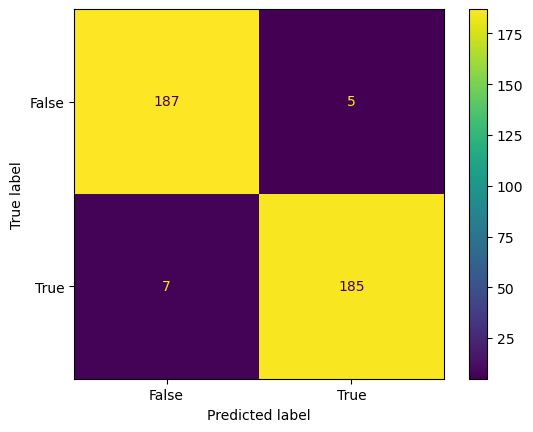

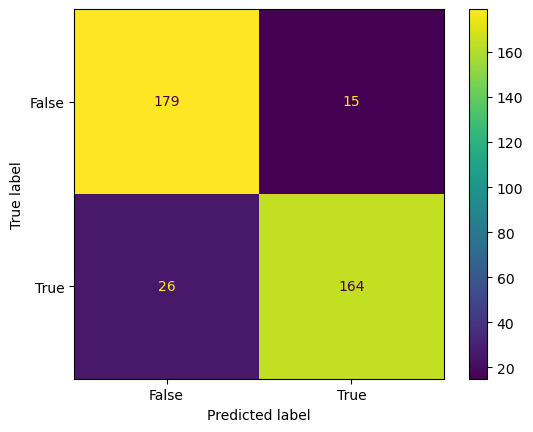

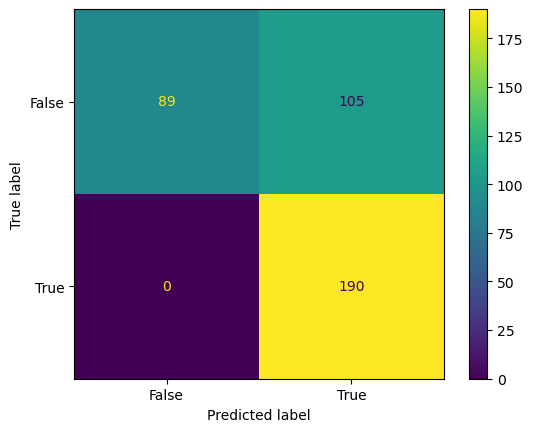

In [ ]:
a.eval()
b.eval()
c.eval()

yan = a(x).detach().numpy()
ybn = b(x).detach().numpy()
ycn = c(x).detach().numpy()

plot_cm(y, ybn)
plot_cm(ybn, yan)
plot_cm(ybn, ycn)